In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
# from importlib import reload

In [2]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=10,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [3]:
client

Client Scheduler: inproc://172.25.0.170/86738/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 10 Memory: 25.00 GB


In [17]:
from cov_3X2 import *
from lsst_utils import *
# from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [8]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [9]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [10]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971795477551902

In [11]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [12]:
cov_des=np.genfromtxt('../covariance_testing/data/DES-Y3//cosmolike_cov_Y3ish/cov_y3_mcal_emu_final.txt')
covG_des=np.genfromtxt('../covariance_testing/data/DES-Y3/cosmolike_cov_Y3ish/cov_y3_mcal_emu_final.txt') 
# covNG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covNG',) 

l_min0=20
l_max0=15000
nl0=20
l_bins=np.logspace(np.log10(l_min0),np.log10(l_max0),nl0+1)
lb=0.5*(l_bins[1:]+l_bins[:-1])

lb15=np.tile(lb,15)
x=lb15<3000
covG_shear=covG_des[:,2].reshape(900,900)[:400,:400] #10 X 2 X 20
cov_shear=cov_des[:,2].reshape(900,900)[:400,:400]

covG_ggl=covG_des[:,2].reshape(900,900)[400:800,400:800] #10 X 2 X 20
cov_ggl=cov_des[:,2].reshape(900,900)[400:800,400:800]

covG_gg=covG_des[:,2].reshape(900,900)[800:900,800:900] #10 X 2 X 20
cov_gg=cov_des[:,2].reshape(900,900)[800:900,800:900]


cov_des=cov_des[:,2].reshape(900,900)
covG_des=covG_des[:,2].reshape(900,900)
# covNG_shear=covNG_shear[x].T[x].T

x=lb<3000
lb=lb[x]
l_bins=l_bins[:16]

In [13]:
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [14]:
l_max=4e4
l_maxW=6e4
l_min=2
# l0=np.arange(l_min,l_maxW)   #np.arange(l_min,l_max)
l0=np.logspace(np.log10(l_min),np.log10(l_maxW),6.e3)
# l0=np.sort(np.append(l0,np.logspace(np.log10(l_maxW),np.log10(l_maxW*10),1.e3)))
l0=np.unique(np.int32(l0))   #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)

In [18]:
#Setup lens redshift bins
source_f='../covariance_testing/data/DES-Y3//cosmolike_cov_Y3ish/lens.nz'
zmin=0
zmax=3.5

nl_bins=4  # Number of tomographic bins
zl_bins=DES_lens_bins(fname=source_f,l=[1])

In [19]:
#Setup source redshift bins
source_f='../covariance_testing/data/DES-Y3//cosmolike_cov_Y3ish/source.nz'
zmin=0
zmax=3.5

nbins=4  # Number of tomographic bins
zs_bins=DES_bins(fname=source_f,sigma_gamma=sigma_gamma,l=[1])

In [20]:
f_sky=5000./(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

In [21]:
f_sky*4*np.pi

1.5230870989335428

In [22]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=False
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [23]:
#Hankel Transform setup
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [24]:
use_window=False
do_sample_variance=True
SSV_cov=False
tidal_SSV=True


In [25]:
import cov_utils
reload(cov_utils)
from cov_utils import *
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *


In [26]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [27]:
corr_ggl=('shear','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

corrs=[corr_ll,corr_ggl,corr_gg]

In [28]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,
                power_spectra_kwargs=power_spectra_kwargs,corrs=corrs,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 1 s, sys: 554 ms, total: 1.56 s
Wall time: 31.4 s


./cov_utils.py:62: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th


In [29]:
gg_i=[(i,i) for i in np.arange(zl_bins['n_bins'])]
XI_W_L.stack_indxs[corr_gg]=gg_i
# XI_W_L.stack_indxs

In [30]:
# %time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 6.17 s, sys: 198 ms, total: 6.37 s
Wall time: 3.5 s


05:23:19 DEBUG:update_title_pos
05:23:19 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:19 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:19 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:19 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
05:23:19 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to DejaVu Sans ('/Users/Deep/anaconda/

05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938e-11
05:23:19 DEBUG:ticklocs array([1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09])
05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938e-11
05:23:19 DEBUG:ticklocs [2e-16, 3e-16, 4e-16, 5e-16, 6e-16, 6.999999999999999e-16, 8e-16, 9e-16, 2e-15, 3.0000000000000002e-15, 4e-15, 5.000000000000001e-15, 6.0000000000000005e-15, 7e-15, 8e-15, 9.000000000000001e-15, 2e-14, 3e-14, 4e-14, 5e-14, 6e-14, 7e-14, 8e-14, 9e-14, 2e-13, 3.0000000000000003e-13, 4e-13, 5e-13, 6.000000000000001e-13, 7e-13, 8e-13, 9e-13, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, 2e-11, 3e-11, 4e-11, 4.9999999999999995e-11, 6e-11, 6.999999999999999e-11, 8e-11, 9e-11, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10, 2e-09, 3.0000000000000004e-09, 4e-09, 5e-09, 6.000000000000001e-09, 7.000000000000001e-09, 8e-09, 9.000000000000001e-09]
05:23:19 DEBUG:update_title_pos
05:23:19 DEBUG:vmin 0.0375654640

05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938e-11
05:23:19 DEBUG:ticklocs array([1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09])
05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938e-11
05:23:19 DEBUG:ticklocs [2e-16, 3e-16, 4e-16, 5e-16, 6e-16, 6.999999999999999e-16, 8e-16, 9e-16, 2e-15, 3.0000000000000002e-15, 4e-15, 5.000000000000001e-15, 6.0000000000000005e-15, 7e-15, 8e-15, 9.000000000000001e-15, 2e-14, 3e-14, 4e-14, 5e-14, 6e-14, 7e-14, 8e-14, 9e-14, 2e-13, 3.0000000000000003e-13, 4e-13, 5e-13, 6.000000000000001e-13, 7e-13, 8e-13, 9e-13, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, 2e-11, 3e-11, 4e-11, 4.9999999999999995e-11, 6e-11, 6.999999999999999e-11, 8e-11, 9e-11, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10, 2e-09, 3.0000000000000004e-09, 4e-09, 5e-09, 6.000000000000001e-09, 7.000000000000001e-09, 8e-09, 9.000000000000001e-09]
05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938

05:23:19 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:19 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:19 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:19 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938e-11
05:23:19 DEBUG:ticklocs array([1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09])
05:23:19 DEBUG:vmin 8.901534958700596e-15 vmax 7.935129272104938e-11
05:23:19 DEBUG:ticklocs [2e-16, 3e-16, 4e-16, 5e-16, 6e-16, 6.999999999999999e-16, 8e-16, 9e-16, 2e-15, 3.0000000000000002e-15, 4e-15, 5.000000000000001e-15, 6.0000000000000005e-15, 7e-1

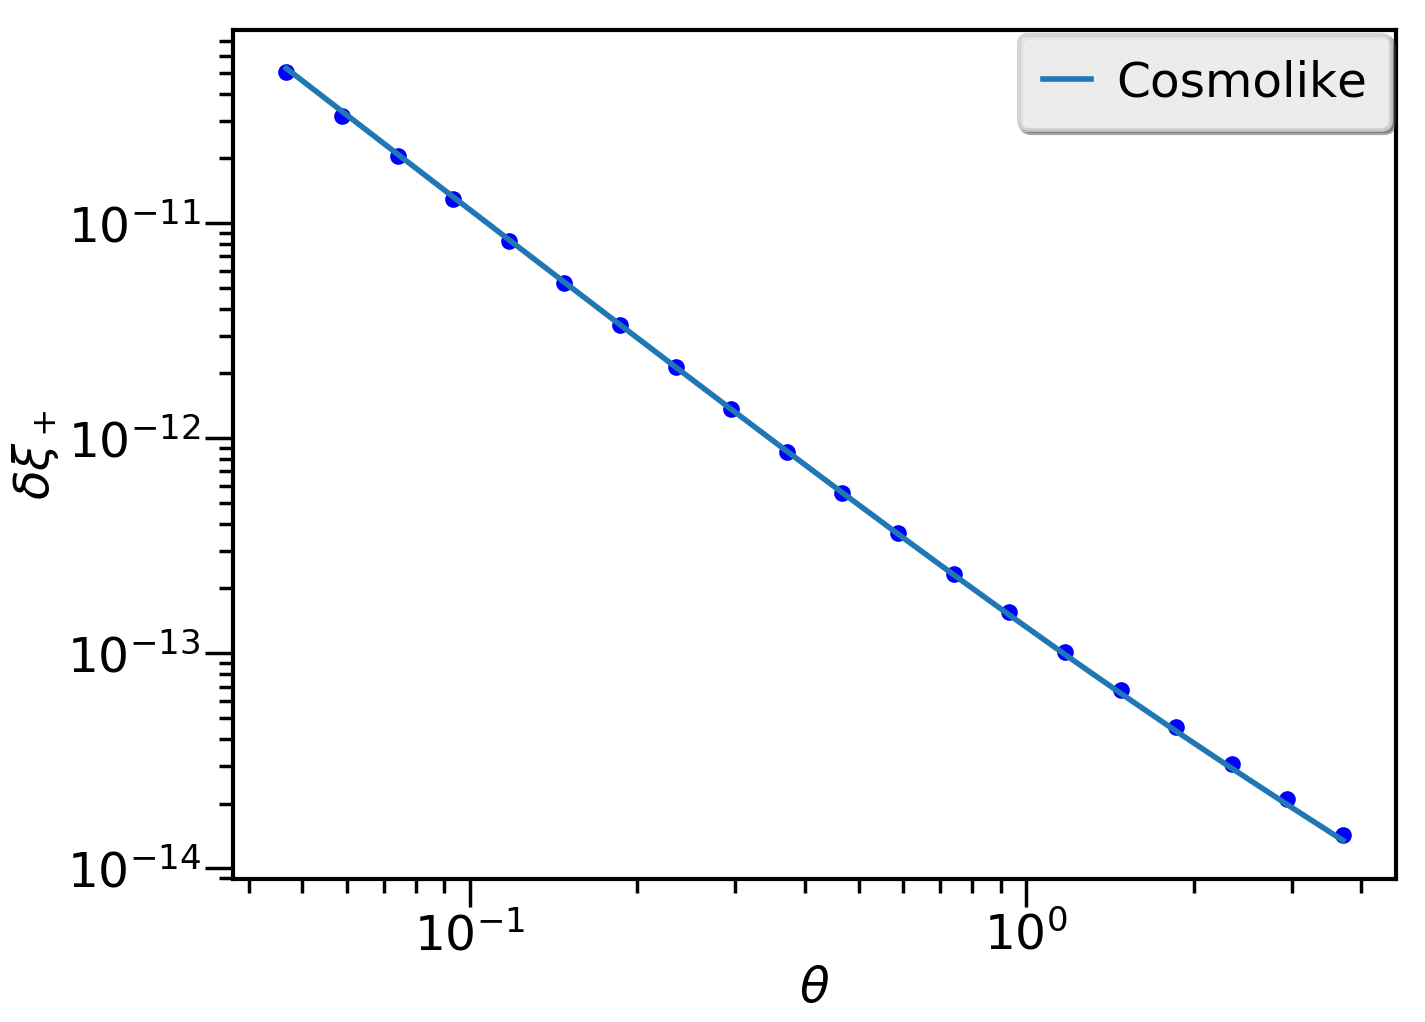

In [31]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
j=i+20
ii=0
sn=0#np.diag(cov_shear)[0]/thb**2*thb[0]**2
cc=xiWG_L['cov'][('shear','shear','shear','shear')][(2,2,2,2)][(ii,ii,ii,ii)].compute()

plot(thb,np.diag(cc['final']),'bo')
# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cov_shear)[i:j],label='Cosmolike')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\delta \xi_+$')
legend()

05:23:20 DEBUG:update_title_pos
05:23:20 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:20 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:20 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:20 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:20 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:20 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:20 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:20 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.

05:23:21 DEBUG:vmin 3.47259210938039e-14 vmax 2.7922701979410274e-10
05:23:21 DEBUG:ticklocs array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08])
05:23:21 DEBUG:vmin 3.47259210938039e-14 vmax 2.7922701979410274e-10
05:23:21 DEBUG:ticklocs [2e-15, 3.0000000000000002e-15, 4e-15, 5.000000000000001e-15, 6.0000000000000005e-15, 7e-15, 8e-15, 9.000000000000001e-15, 2e-14, 3e-14, 4e-14, 5e-14, 6e-14, 7e-14, 8e-14, 9e-14, 2e-13, 3.0000000000000003e-13, 4e-13, 5e-13, 6.000000000000001e-13, 7e-13, 8e-13, 9e-13, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, 2e-11, 3e-11, 4e-11, 4.9999999999999995e-11, 6e-11, 6.999999999999999e-11, 8e-11, 9e-11, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10, 2e-09, 3.0000000000000004e-09, 4e-09, 5e-09, 6.000000000000001e-09, 7.000000000000001e-09, 8e-09, 9.000000000000001e-09, 2e-08, 3.0000000000000004e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 8e-08, 9e-08]
05:23:21 DEBUG:vmin 0.03756546406691488 vmax 4.

05:23:21 DEBUG:update_title_pos
05:23:21 DEBUG:vmin 3.47259210938039e-14 vmax 2.7922701979410274e-10
05:23:21 DEBUG:ticklocs array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08])
05:23:21 DEBUG:vmin 3.47259210938039e-14 vmax 2.7922701979410274e-10
05:23:21 DEBUG:ticklocs [2e-15, 3.0000000000000002e-15, 4e-15, 5.000000000000001e-15, 6.0000000000000005e-15, 7e-15, 8e-15, 9.000000000000001e-15, 2e-14, 3e-14, 4e-14, 5e-14, 6e-14, 7e-14, 8e-14, 9e-14, 2e-13, 3.0000000000000003e-13, 4e-13, 5e-13, 6.000000000000001e-13, 7e-13, 8e-13, 9e-13, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, 2e-11, 3e-11, 4e-11, 4.9999999999999995e-11, 6e-11, 6.999999999999999e-11, 8e-11, 9e-11, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10, 2e-09, 3.0000000000000004e-09, 4e-09, 5e-09, 6.000000000000001e-09, 7.000000000000001e-09, 8e-09, 9.000000000000001e-09, 2e-08, 3.0000000000000004e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 8e-08, 9e-08]
05:23:21 DEBUG:

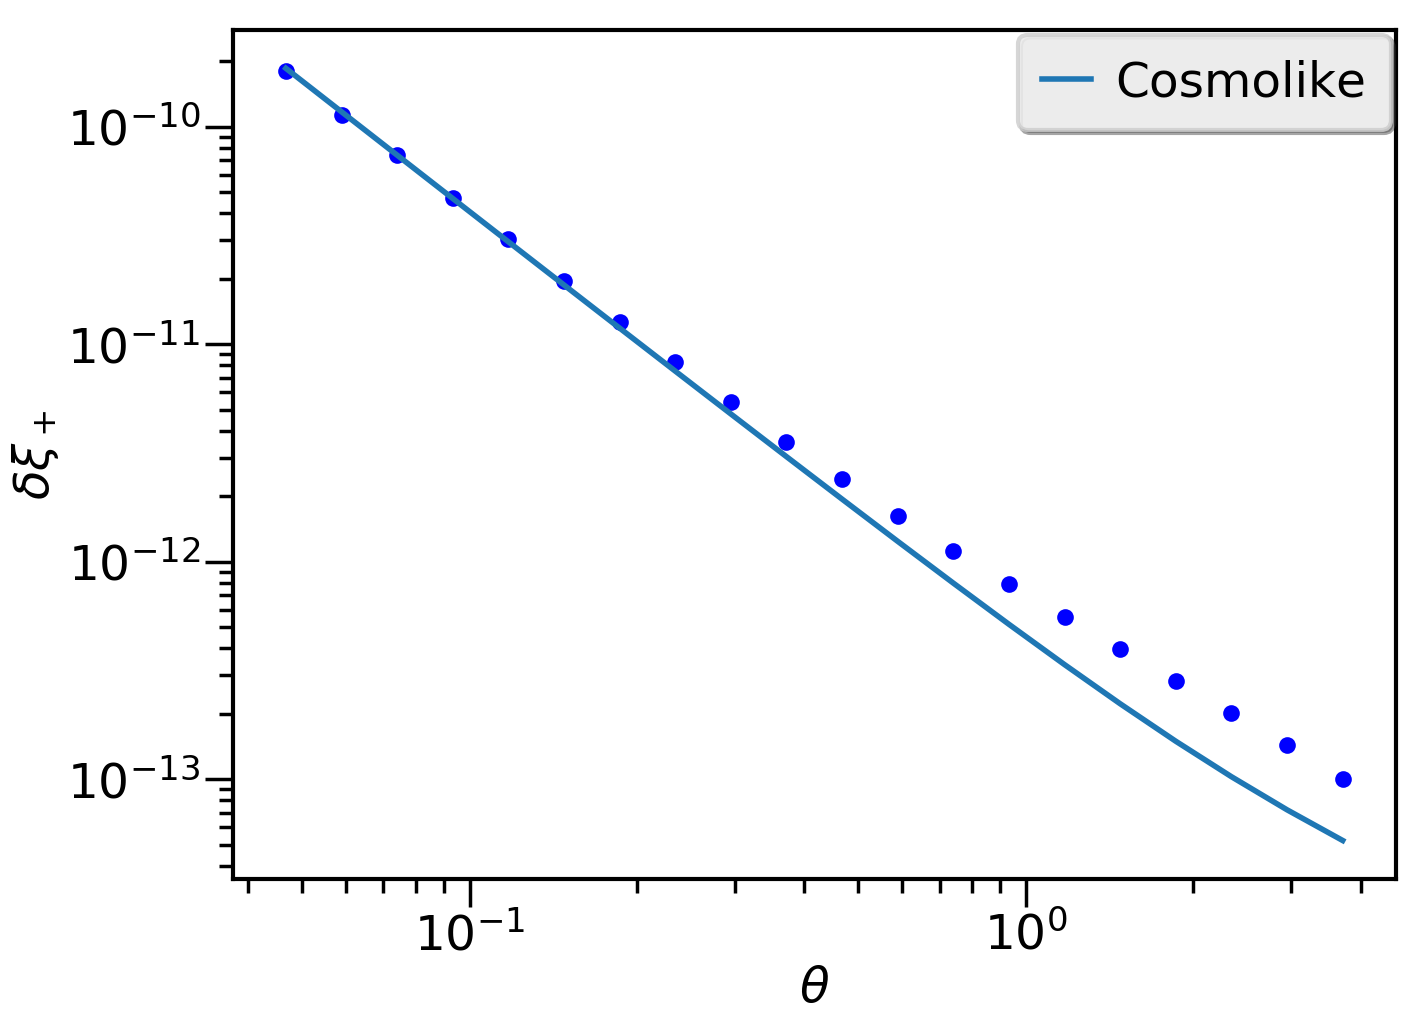

In [32]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=19
i=ii*20
j=i+20
ii=3
sn=0#np.diag(cov_shear)[0]/thb**2*thb[0]**2
cc=xiWG_L['cov'][('shear','shear','shear','shear')][(2,2,2,2)][(ii,ii,ii,ii)].compute()

plot(thb,np.diag(cc['final']),'bo')
# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cov_shear)[i:j],label='Cosmolike')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\delta \xi_+$')
legend()

05:23:22 DEBUG:update_title_pos
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.

05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.700000000000

05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:22 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:22 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.700000000000

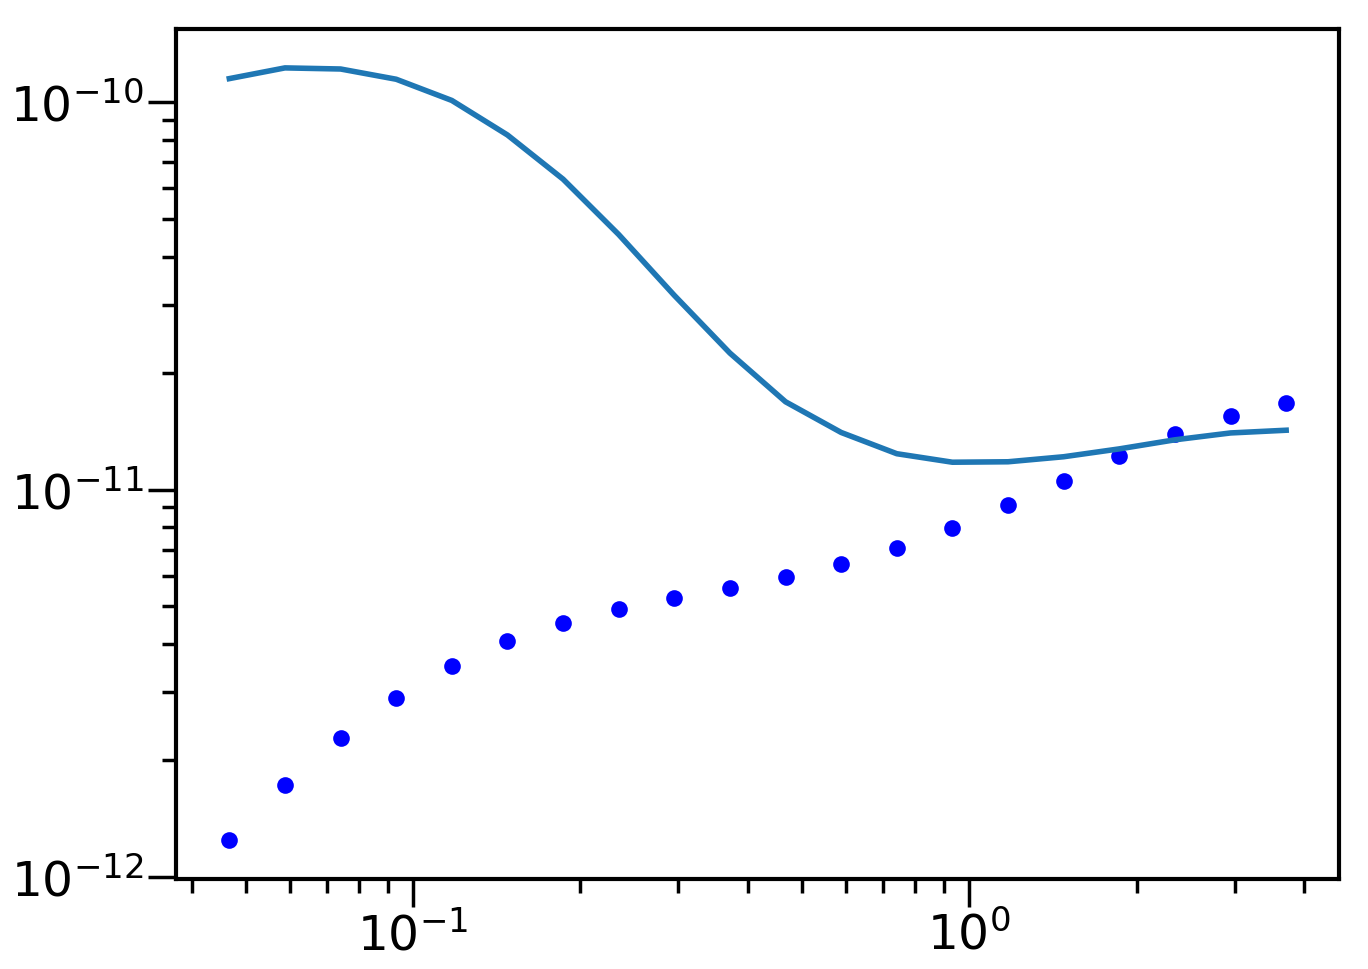

In [33]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
ii2=1
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,1,0)].compute()
cc3=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,0)].compute()
# cc=xiWG_L['cov'][('galaxy','shear','galaxy','shear')][(0,2,0,2)][(0,0,0,0)].compute()

# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cc2))
# plot(thb,np.diag(cc3['final']),'ro')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

05:23:23 DEBUG:update_title_pos
05:23:23 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:23 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:23 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:23 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:23 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:23 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:23 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:23 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.

05:23:23 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:23 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:23 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.700000000000

05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.700000000000

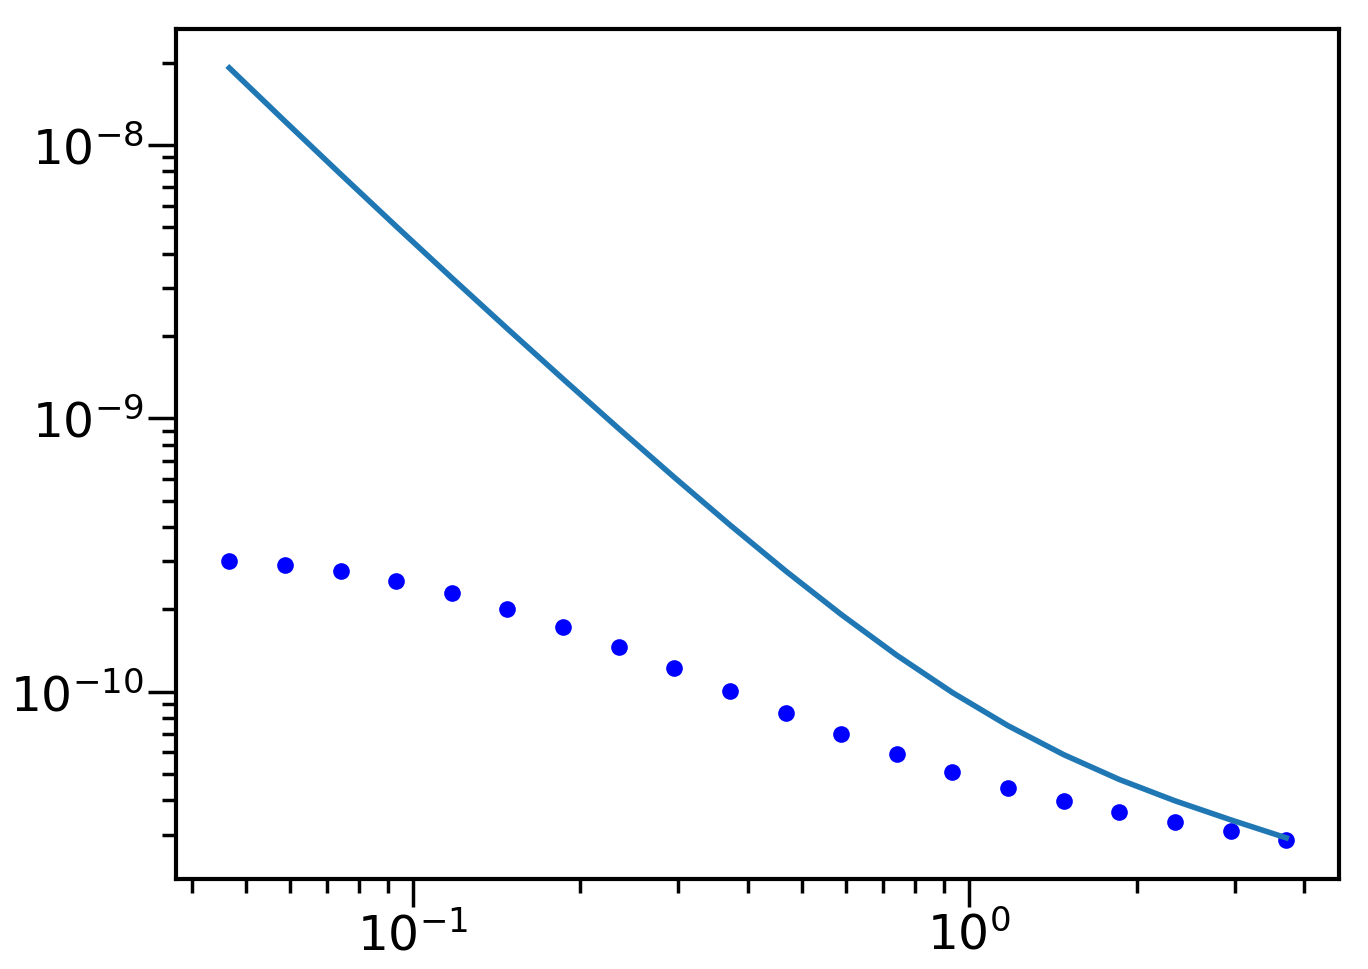

In [34]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
ii2=0
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,0)].compute()


plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cov_ggl)[i:i+20])
# plot(thb,np.diag(cc3['final']),'ro')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

05:23:24 DEBUG:update_title_pos
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.

05:23:24 DEBUG:vmin 8.442670550479914e-12 vmax 8.149628304357925e-08
05:23:24 DEBUG:ticklocs [2e-13, 3.0000000000000003e-13, 4e-13, 5e-13, 6.000000000000001e-13, 7e-13, 8e-13, 9e-13, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, 2e-11, 3e-11, 4e-11, 4.9999999999999995e-11, 6e-11, 6.999999999999999e-11, 8e-11, 9e-11, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10, 2e-09, 3.0000000000000004e-09, 4e-09, 5e-09, 6.000000000000001e-09, 7.000000000000001e-09, 8e-09, 9.000000000000001e-09, 2e-08, 3.0000000000000004e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 8e-08, 9e-08, 2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06]
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs [0.002, 0.003, 0.004, 0.005, 0.

05:23:24 DEBUG:vmin 8.442670550479914e-12 vmax 8.149628304357925e-08
05:23:24 DEBUG:ticklocs array([1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06])
05:23:24 DEBUG:vmin 8.442670550479914e-12 vmax 8.149628304357925e-08
05:23:24 DEBUG:ticklocs [2e-13, 3.0000000000000003e-13, 4e-13, 5e-13, 6.000000000000001e-13, 7e-13, 8e-13, 9e-13, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, 2e-11, 3e-11, 4e-11, 4.9999999999999995e-11, 6e-11, 6.999999999999999e-11, 8e-11, 9e-11, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7.000000000000001e-10, 8e-10, 9e-10, 2e-09, 3.0000000000000004e-09, 4e-09, 5e-09, 6.000000000000001e-09, 7.000000000000001e-09, 8e-09, 9.000000000000001e-09, 2e-08, 3.0000000000000004e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 8e-08, 9e-08, 2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06]
05:23:24 DEBUG:vmin 0.03756546406691488 vmax 4.621561730260003
05:23:24 DEBUG:ticklocs array([1.

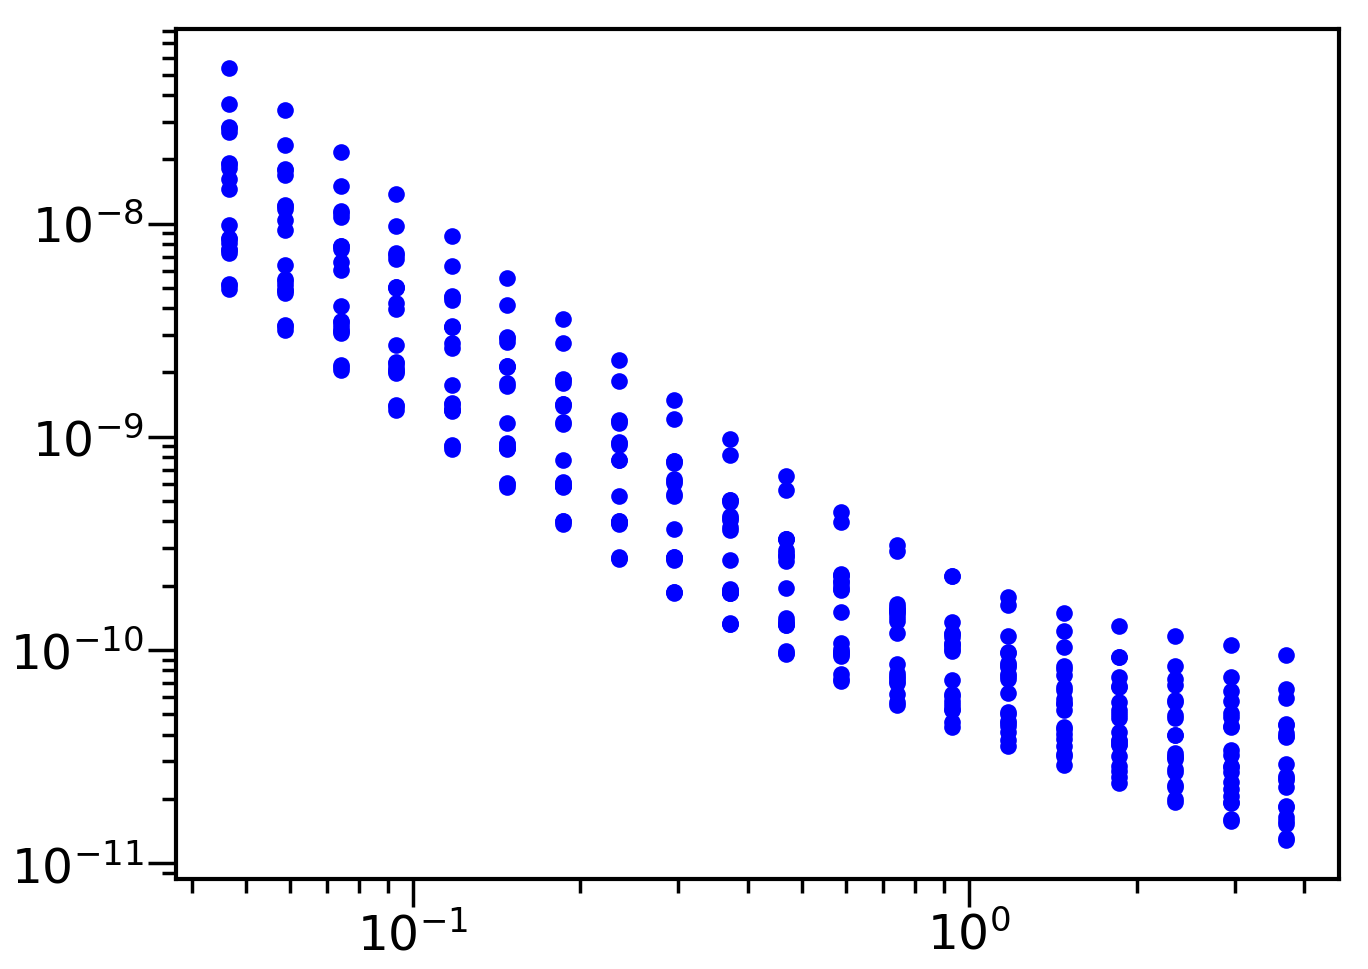

In [35]:
plot(np.tile(thb,20),np.diag(cov_ggl),'bo')
xscale('log')
yscale('log')

In [ ]:
%time xiW_L=xiWG_L['stack'].compute()

In [ ]:
f=1
# cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
# print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corr_shear2=cc.corr_matrix(covG_ggl)
pcolor(corr_shear2,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Cosmolike')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corr_shear=cc.corr_matrix(covG_des)
pcolor(corr_shear,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Cosmolike')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
pcolor(corr_shear-corrW,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xticks([])
yticks([])

In [ ]:
pcolor(cov_des/xiW_L['cov']-1,cmap='seismic',vmin=-1,vmax=1,)
colorbar()

In [ ]:
plot(thb,XI_W_L.xi_bin_utils[(2,2)]['norm']/thb**2)
xscale('log')
# yscale('log')

In [ ]:
cov_test=np.genfromtxt('shape_noise_cov.dat')
cov_test2=np.genfromtxt('shape_noise_diag.dat')

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
j=i+20
sn=np.diag(cov_shear)[0]/thb**2*thb[0]**2
# NN=np.diag(xiH['cov'])[i:j]-sn/2.
# plot(thb,np.diag(xiH['cov'])[i:j],'--')
# plot(thb,np.diag(xiH2['cov'])[i:j],'--')
plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
# plot(thb,np.diag(cov_test),':')
# plot(thb,cov_test2,':')
# plot(thb,sn,':')
plot(thb,np.diag(cov_shear)[i:j])
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=1
i=ii*20
j=i+20

cc=xiWG_L['cov'][('galaxy','galaxy','galaxy','galaxy')][(0,0,0,0)][(ii,ii,ii,ii)].compute()

sn=np.diag(cov_gg)[0]/thb**2*thb[0]**2
# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cov_gg)[i:j])
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=4
i=ii*20
ii2=0
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,1)].compute()
# cc=xiWG_L['cov'][('galaxy','shear','galaxy','shear')][(0,2,0,2)][(0,0,0,0)].compute()

# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cc2))
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
XI_W_L.galaxy_utils.nz_F

In [ ]:
corrs_t=('shear','galaxy','shear','galaxy')
indxs_t=(0,0,0,0)
XI_W_L.cov_utils.get_SN(XI_W_L.SN,corrs_t,indxs_t)

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
ii2=1
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,1,0)].compute()
cc3=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,0)].compute()
# cc=xiWG_L['cov'][('galaxy','shear','galaxy','shear')][(0,2,0,2)][(0,0,0,0)].compute()

# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cc2))
# plot(thb,np.diag(cc3['final']),'ro')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
plot(thb,np.diag(xiW_L['cov'])[i:j]-cov_test2,'--')
plot(thb,np.diag(xiH['cov'])[i:j]-cov_test2,'--')
plot(thb,(np.diag(cov_shear)[i:j]-cov_test2)*1.2)

xscale('log')
yscale('log')

In [ ]:
plot(thb,np.diag(xiW_L['cov'])[i:j],':')
plot(thb,np.diag(cov_test),':')
plot(thb,cov_test2,':')

xscale('log')
yscale('log')

In [ ]:
plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
plot(thb,np.diag(cov_shear/xiW_L['cov'])[:20])
xscale('log')
# yscale('log')

In [ ]:
d2r/60

In [ ]:
XI_H.z_bins['shear'][0]['nz']

In [ ]:
XI_H.SN

In [ ]:
ns=XI_H.z_bins['shear'][0]['nz']*3600/d2r**2
sigma_gamma**2/ns

In [ ]:
XI_H.z_bins['shear'][0]['SN']

In [ ]:
plot(np.diag(xiW_L['cov']/xiH['cov'])[:20])
ylim(0.9,1.1)

In [ ]:
crash

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        plot(CL.l,clG['cl']['cl'][corr][(i,j)].compute()/cls,label=(i,j))
        xscale('log')
#         yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        hlines(1,2,1000)
        legend()
        ylim(0.9,1.1)
    show()

In [ ]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        cls_b=CL.binning.bin_1d(xi=cls,bin_utils=CL.cl_bin_utils)
        plot(lb,cls_b,color=cp[j],ls=':')
        
    xscale('log')
    yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    legend(ncol=3)
    show()

In [ ]:
def func(x):
    return x+1

In [ ]:
y=dask.delayed(func)(10)

In [ ]:
y.compute()

In [ ]:
y